In [3]:
import numpy as np
import pandas as pd

In [4]:
df = pd.read_csv("data/complete_data.csv")

In [5]:
df.shape

(5579, 73)

In [6]:
## nan percentage
import pandas as pd
nan_counts = df.isna().sum()
nan_percentage = (nan_counts / len(df)) * 100
nan_summary = pd.DataFrame({'NaN Count': nan_counts, 'NaN Percentage': nan_percentage})
nan_summary = nan_summary[nan_summary['NaN Count'] > 0].sort_values(by='NaN Count', ascending=False)
nan_summary

,NaN Count,NaN Percentage
Team_tomatoMeter,1228,22.011113
Cast_tomatoMeter,1196,21.437534
Cast_audienceScore,1149,20.595089
Team_audienceScore,1127,20.200753
Team_Tomato_Meter_Mean,372,6.667862
Cast_Tomato_Meter_Mean,371,6.649937
Team_Audience_Score_Mean,370,6.632013
Cast_Audience_Score_Mean,370,6.632013
Team_Review_Score_sum,369,6.614089
Team_Review_Score_mean,369,6.614089


In [7]:
df.fillna(0, inplace=True)

In [8]:
import pandas as pd
all_columns = df.columns

continuous_features = [col for col in all_columns if df[col].dtype in ['int64', 'float64'] 
                       and df[col].nunique() > 10]


bool_features = [col for col in all_columns if df[col].nunique() == 2 and sorted(df[col].unique()) == [0, 1]]

categorical_features = [col for col in all_columns if df[col].dtype == 'object' or 
                        (df[col].dtype in ['int64', 'float64'] and df[col].nunique() <= 10)]

# 输出各类变量
print("🔹 continuous_features:", continuous_features)
print("🔹 bool_features:", bool_features)
print("🔹 categorical_features:", categorical_features)


🔹 continuous_features: ['box_office', 'budget', 'runtime', 'sadness', 'joy', 'love', 'anger', 'fear', 'surprise', 'Team_Review_Score_sum', 'Team_Review_Score_mean', 'Team_Audience_Score_Mean', 'Team_Tomato_Meter_Mean', 'Team_Num_reviews', 'Cast_Review_Score_sum', 'Cast_Review_Score_mean', 'Cast_Audience_Score_Mean', 'Cast_Tomato_Meter_Mean', 'Cast_Num_reviews', 'Cast_audienceScore', 'Cast_tomatoMeter', 'Team_audienceScore', 'Team_tomatoMeter', 'cpi', 'box_office_gross', 'box_office_adjusted', 'collection_id', 'collection_box_office_average']
🔹 bool_features: ['Unnamed: 27', 'columbia pictures', 'new line cinema', 'paramount pictures', 'buena vista pictures distribution', 'warner bros. pictures', '20th century fox', 'universal pictures', 'sony pictures releasing', 'warner bros.', 'dolby digital', 'dts', 'sdds', 'dolby sr', 'surround', 'nudity', 'sexual content', 'violence', 'pervasive language', 'sexuality', 'thematic elements', 'drug use', 'some violence', 'some language', 'language', 

In [9]:
# bool transfermation
df[bool_features] = df[bool_features].astype(int)


## Feature selection & preprocess
- Removed highly correlated variables with **box_office_adjusted**, including box_office and other revenue-related columns, to prevent data leakage.
- Applied Point-Biserial correlation to boolean features and dropped those with an absolute correlation below 0.05 or an insignificant p-value.
- Performed log transformation on **box_office_adjusted** to reduce skewness.
- Removed outliers (log data<10 and >20)

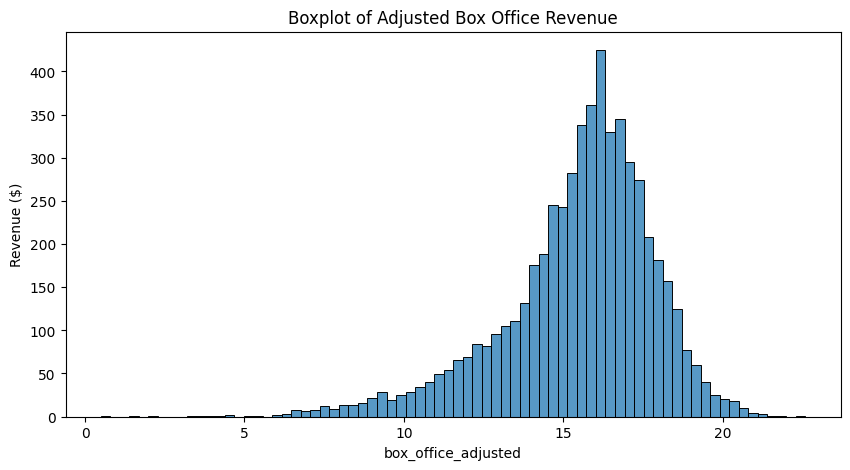

In [10]:
df["box_office_adjusted"].describe()
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(10, 5))
sns.histplot(np.log1p(df['box_office_adjusted'] ))
plt.title("Boxplot of Adjusted Box Office Revenue")
plt.ylabel("Revenue ($)")
plt.show()


In [11]:
from scipy.stats import pointbiserialr
drop_columns = [
    'box_office',             
    'box_office_gross',          
    'collection_box_office_average',  
    'collection_id',             
    'Unnamed: 27' ,
    "box_office_adjusted"              
]
low_correlation_features = []
for feature in bool_features:
    corr, p_value = pointbiserialr(df[feature], df['box_office_adjusted'])
    if abs(corr) < 0.05 or p_value > 0.05:  
        low_correlation_features.append(feature)


drop_columns += low_correlation_features
len(drop_columns)


37

In [12]:
df1= df[(np.log1p(df['box_office_adjusted'])>10) & (np.log1p(df['box_office_adjusted'])<20)]
y = np.log1p(df1['box_office_adjusted'])
X = df1.drop(columns=drop_columns)

In [13]:
X.shape

(5337, 37)

## Model 
I trained the model on log-transformed data; For error calculation, I applied an exponential transformation to revert the predictions back to the original scale before computing the error metrics.


#### problem 
- Missing key features such as actors' commercial value, audience discussion trends, and market hype, which significantly impact box office performance.
- Though predictions seems well-fitted in the log-transformed space, there are large absolute errors when converted back to the original scale.

## XGBoost

In [14]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(((y_true - y_pred) / y_true) ** 2)) * 100
rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))
print(f'XGBoost RMSE: {rmse:.4f}')
rmspe_value = rmspe(np.expm1(y_test), np.expm1(y_pred))
print(f'XGBoost RMSPE: {rmspe_value:.2f}%')


XGBoost RMSE: 41442320.1306
XGBoost RMSPE: 1494.59%


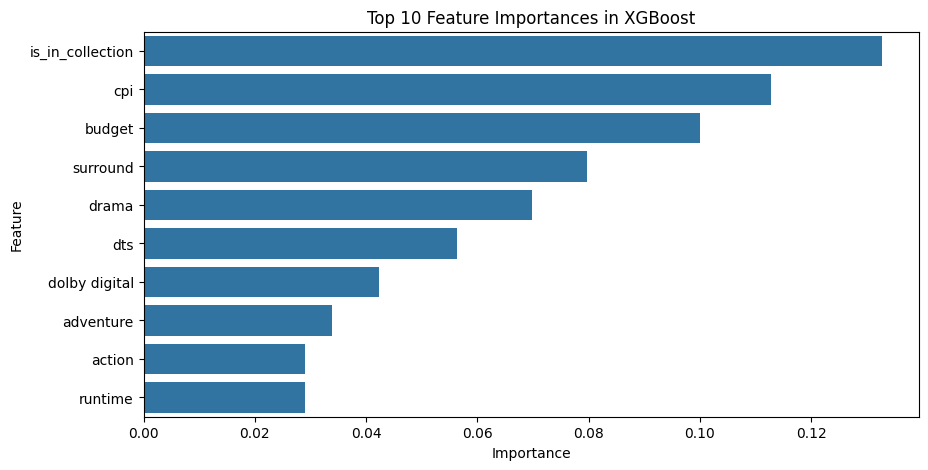

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# 获取特征重要性
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# 画出前 10 个重要特征
plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Feature Importances in XGBoost')
plt.show()


## Random Forest 

In [17]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))
print(f'Random Forest RMSE: {rmse:.4f}')
rmspe_value = rmspe(np.expm1(y_test), np.expm1(y_pred))
print(f'Random Forest RMSPE: {rmspe_value:.2f}%')


Random Forest RMSE: 41461055.9061
Random Forest RMSPE: 1545.46%


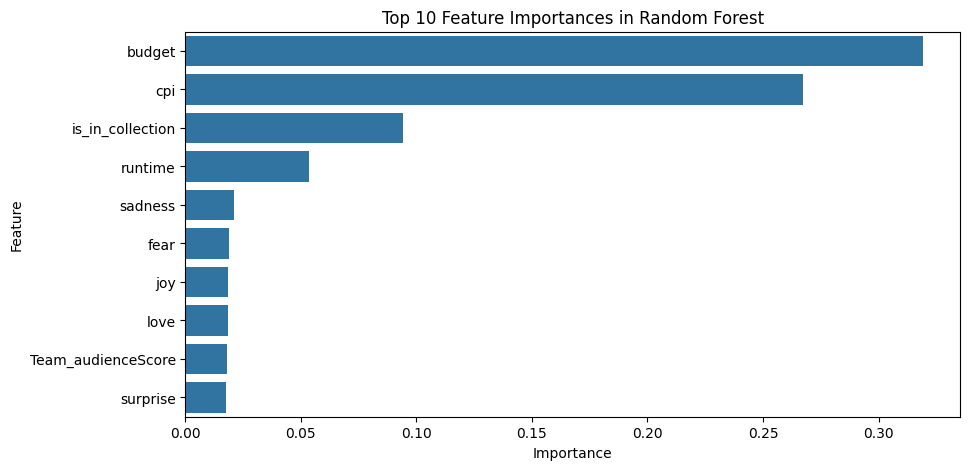

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# 获取特征重要性
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Feature Importances in Random Forest')
plt.show()


## MLP (deep learning)

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 归一化数据（MLP 需要标准化输入）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 划分训练 & 测试集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 构建 MLP 模型
mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # 输出票房预测
])

# 编译模型
mlp_model.compile(optimizer='adam', loss='mse')

# 训练模型
mlp_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1)

# 预测票房
y_pred_mlp = mlp_model.predict(X_test)




Epoch 1/100


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - loss: 116.6974 - val_loss: 5.3227
Epoch 2/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step - loss: 6.3371 - val_loss: 4.7371
Epoch 3/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - loss: 4.8997 - val_loss: 4.2475
Epoch 4/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - loss: 4.4196 - val_loss: 3.6814
Epoch 5/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 4.2301 - val_loss: 4.2144
Epoch 6/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step - loss: 3.9828 - val_loss: 3.4718
Epoch 7/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - loss: 3.7372 - val_loss: 3.5275
Epoch 8/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - loss: 3.7500 - val_loss: 3.2315
Epoch 9/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - loss: 3.4840 - val_loss: 2.9904
Epoch 10/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - loss: 3.4370 - val_loss: 3.0826
Epoch 11/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step - loss: 3.1810 - val_loss: 2.9572
Epoch 12/100
121/121 ━━━━━━━━

In [20]:
rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_mlp)))
print(f'Random Forest RMSE: {rmse:.4f}')
rmspe_value = rmspe(np.expm1(y_test), pd.Series(np.expm1(y_pred_mlp).flatten()))
print(f'Random Forest RMSPE: {rmspe_value:.2f}%')

Random Forest RMSE: 50095204.7969
Random Forest RMSPE: 8964.80%
